## 0.0 Import packages and load sensor data

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import find_peaks

# load and label the data
signals = pd.read_csv ('signals.csv', names=['Channel_1', 'Channel_2'])

## 1.0 Plot the sensor data in the time and frequency domain

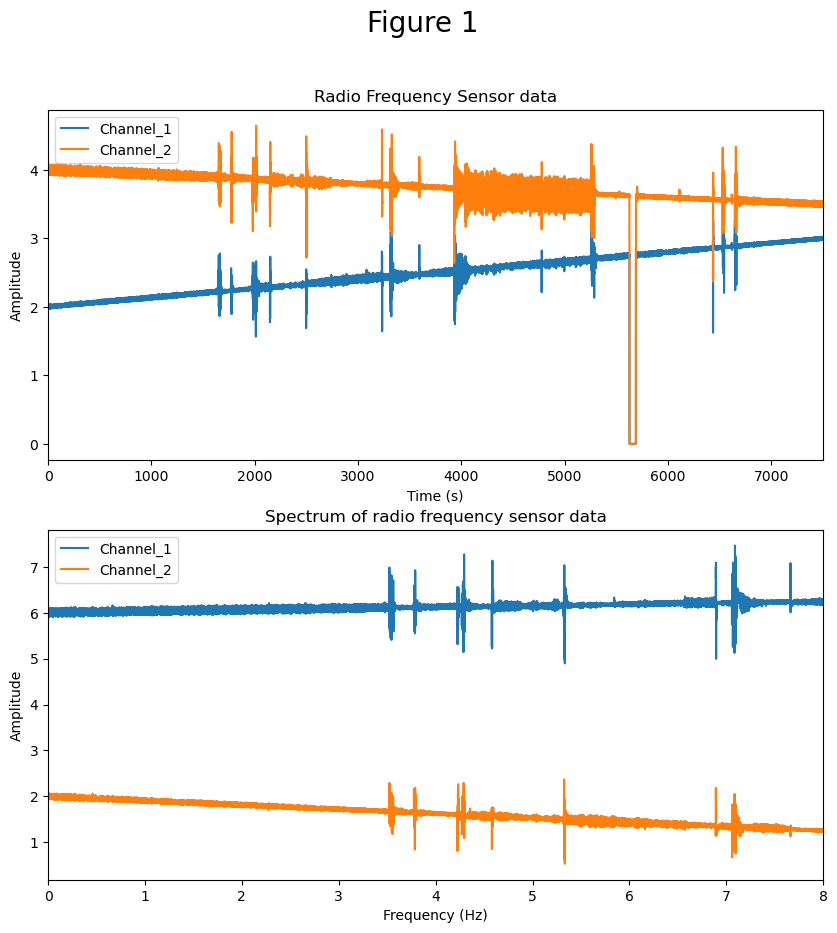

In [2]:
fs = 16 # sampling frequency of 16 Hz
N = len(signals) # number of samples
duration = N/fs # duration of signal
T = 1/fs # sample spacing

# adjusting the x-axis to reflect time in seconds
time_axis = np.linspace(0, duration, N)

# obtaining the FFT of the signals
fft_signals = fft(signals)
frequency_axis = fftfreq(N, T)[:N//2] # adjust frequency access to show appropriate spectrum

# plotting the sensor data
plt.figure(figsize=(10,10)).suptitle('Figure 1', fontsize=20)
plt.subplot(2, 1, 1)
plt.plot(time_axis, signals)
plt.title('Radio Frequency Sensor data')
plt.legend(['Channel_1', 'Channel_2'])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.xlim([0, time_axis[-1]])


plt.subplot(2, 1, 2)
plt.plot(frequency_axis, abs(fft_signals[0:N//2]))
plt.title('Spectrum of radio frequency sensor data')
plt.legend(['Channel_1', 'Channel_2'])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim([0, fs/2]) # Nyquist Frequency
plt.show()

As shown in Figure 1, the signal is not centered around the centre line - to adjust for this and to aid future analysis - a running average filter will remove this slopped artefact. This also could be the reason for the unusual Spectrum shown in Figure 1 also. A moving average filter is necessary for this as the average of both signals increases/ decreases as time goes on and therefore a single average will not work to remove these slopes. 

As well as this a number of high noise segments can be see - for example between roughly 4,000 seconds and 5,200 seconds in Channel 2. There is also a sharp decrease in both signals at about 5,700 seconds - another approach will have to be taken after the moving average filter to control for these noises that could be explained my the participant moving while the signals were recorded.

## 1.1 Look at a few time segments of the channels from the signals

In order to better understand the signals that we want to investigate further, the signal will be cute into smaller time segments. 

Although more throughout investigated while developing this code (each time segment was printed out and observed), in the interest of neatness, only 6 segments will be plotted and shown below.

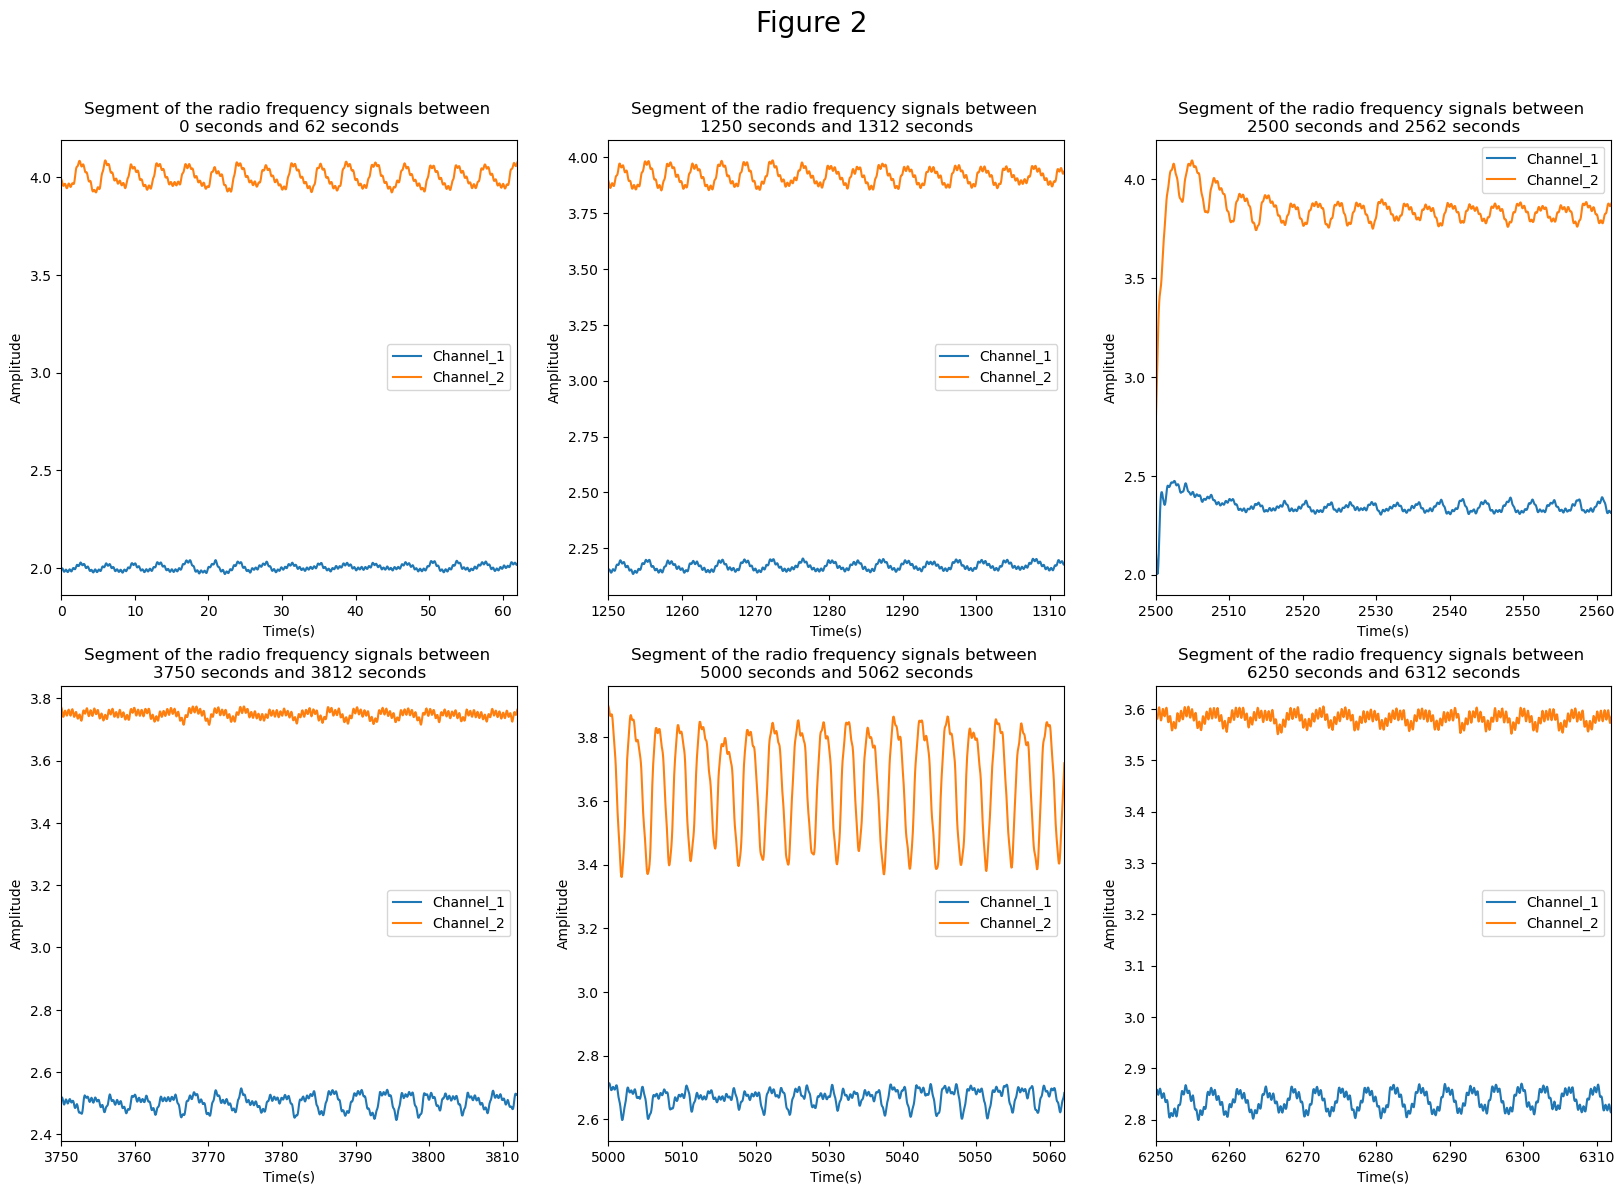

In [3]:
w = 1000 #number of samples in segment
ind = 0
plt.figure(figsize=(20,13)).suptitle('Figure 2', fontsize=20)

for i in range(0, N-w, w*20):
    ind+=1
    plt.subplot(2, 3, ind)
    time_axis_segment = np.linspace(i//fs, (i+w)//fs, w)
    plt.plot(time_axis_segment, signals[i:i+w])
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    plt.legend(['Channel_1', 'Channel_2'])
    plt.title('Segment of the radio frequency signals between \n'+str(int(time_axis_segment[0]))+' seconds and '+str(int(time_axis_segment[-1]))+' seconds')
    plt.xlim([time_axis_segment[0], time_axis_segment[-1]])
plt.show()

From looking at the individual segments of the signals shown in Figure 2, the periodic up and down sinusoid-like characteristics of the signal suggests breathing (i.e. the amplitude changes as the person breaths in and out as their chest expands and contrasts). 

From this up and down movement, each breath can be counted by using a peak detection algorithm and thus the breathing rate can be realised. However, it is evident that there is a significant amount of noise in the signals which might mean that instead of detecting the absolute peak of the breath, another outlier might be selected which would make the breathing rate inaccurate. The moving average filtered approach mentioned under Figure 1 will not reduce this noise significantly which means that an additional approach to this (i.e. another filtering method) will have to be used as well. A low-pass filter would be most appropriate to reduce this noise.

## 2.0 Create a moving average filter with a specified window length

In [4]:
def signals_avg_filt(data, window):
    N = len(data)
    avg_filt = []
    
    for i in range(0, N, window):
        segment_avg = np.mean(data[i:i+window]) # get the average amplitude across a window length of samples        
        avg_filt.extend(segment_avg*np.ones(window)) # put this average in each cell of an array that has the same length as the window length 
        
    data_avg_filtered = data - avg_filt # take the average value from each of the corresponding indicies in the original signal
    
    return data_avg_filtered

## 2.1 Apply filter above to signals - show signals in both the time and frquency domain
A window length of 1000 samples (~63 seconds, or ~1 minute) was chosen to start out with.

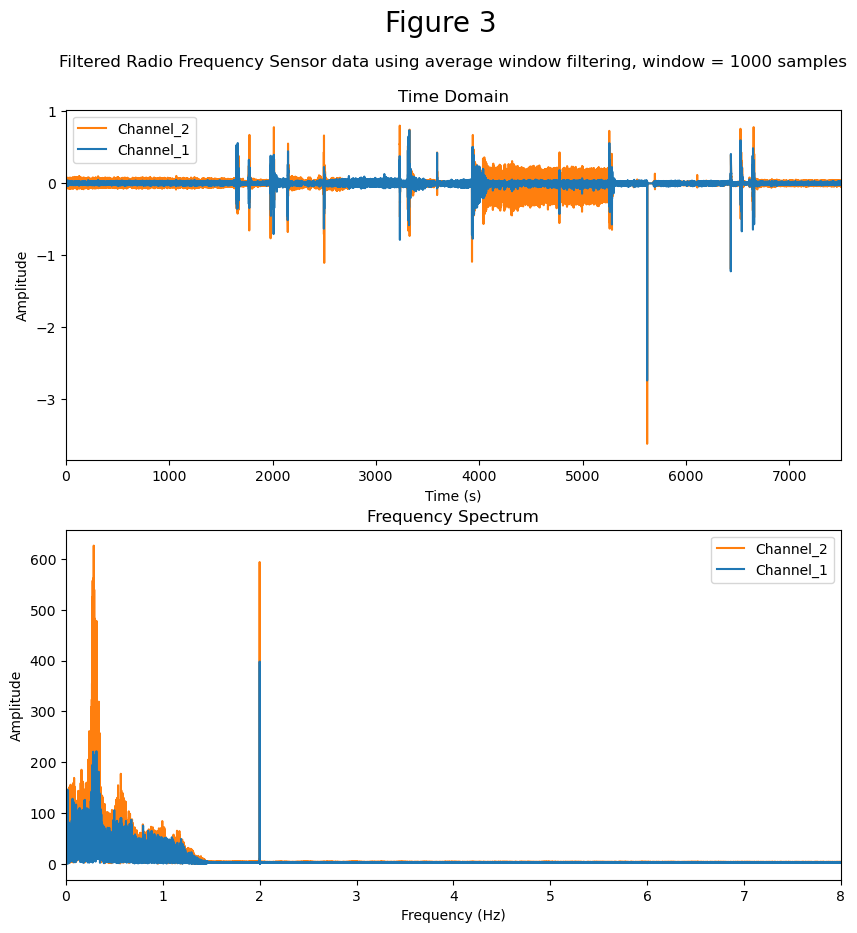

In [5]:
window = 1000
# calculate the time domain of the averaged signals
avg_sig_1 =  signals_avg_filt(signals['Channel_1'], window)
avg_sig_2 =  signals_avg_filt(signals['Channel_2'], window)

# calculate the frequency domain of the averaged signals
fft_avg_sig_1 = fft(avg_sig_1.tolist())
fft_avg_sig_2 = fft(avg_sig_2.tolist())

# plotting the average signal data
plt.figure(figsize=(10,10)).suptitle('Figure 3', fontsize=20)

# plot the time domain
plt.subplot(2, 1, 1)
plt.plot(time_axis, avg_sig_2, color="#ff7f0e")
plt.plot(time_axis, avg_sig_1, color="#1f77b4")
plt.title('Filtered Radio Frequency Sensor data using average window filtering, window = '+str(window)+' samples\n\nTime Domain')
plt.legend(['Channel_2', 'Channel_1'])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.xlim([0, time_axis[-1]])

# plot the frequency domain
plt.subplot(2, 1, 2)
plt.plot(frequency_axis, np.abs(fft_avg_sig_2[0:N//2]), color="#ff7f0e")
plt.plot(frequency_axis, np.abs(fft_avg_sig_1[0:N//2]), color="#1f77b4")
plt.title('Frequency Spectrum')
plt.legend(['Channel_2', 'Channel_1'])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim([0, 8])
plt.show()

Now that the signals are centered at the center line, further analysis will be easier.

### 2.1.1 The Frequency Spectrum of the moving-average-filtered signal
As a normal beathing rate is usually <=20 breaths per minute or <=1/3 seconds, a high amplitude can be seen around this value, as expected. However, there is a similarly a large amplitude for approximately 2Hz - this very high magnitude is more than likely contributing to noise from motion artefact etc.. 

A low-pass filter will be used to try and remove this 2 Hz-relatednoise and all other contributing high frequencies.

## 3.0 Create low-pass filter

The low-pass filter that is desired would attenuate frequencies from roughly 1.5 Hz onwards for both radio frequency signals - this value is used instead of 2 Hz to ensure that the 2Hz is attenuated as much as possible without potentially reducing other important frequencies. Therefore a cut-off frequency of 1.5Hz will be used. 

For the purposes of this problem a Butterworth Finite Impulse Response (FIR) filter will be used. 

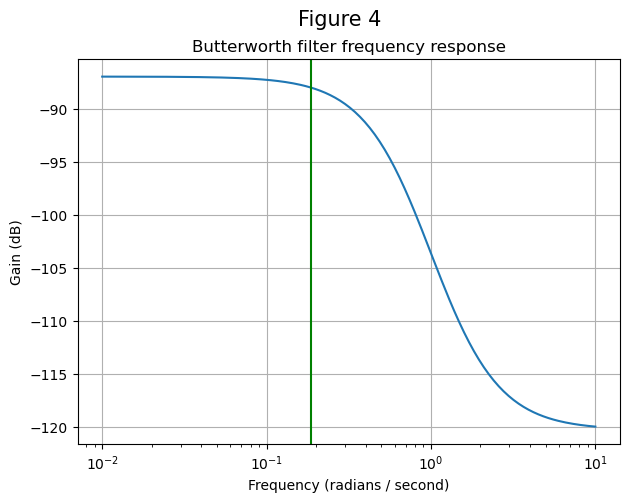

In [6]:
# set filter parameters
order = 10 # filter order of 10
Wn = 1.5 # critical frequency
fsample = 16
N = len(signals) # number of samples

# design the filter
b, a = signal.butter(order, Wn, btype='low', analog=False, output='ba', fs = fsample)
w, h = signal.freqs(b, a)
plt.figure(figsize=(7,5)).suptitle('Figure 4', fontsize=15)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency (radians / second)')
plt.ylabel('Gain (dB)')
plt.grid(True)
plt.axvline(Wn*2/fs, color='green') # cutoff/ critical frequency in relation to the Nyquist frequency
plt.show()

## 3.1 Use the designed low-pass filter

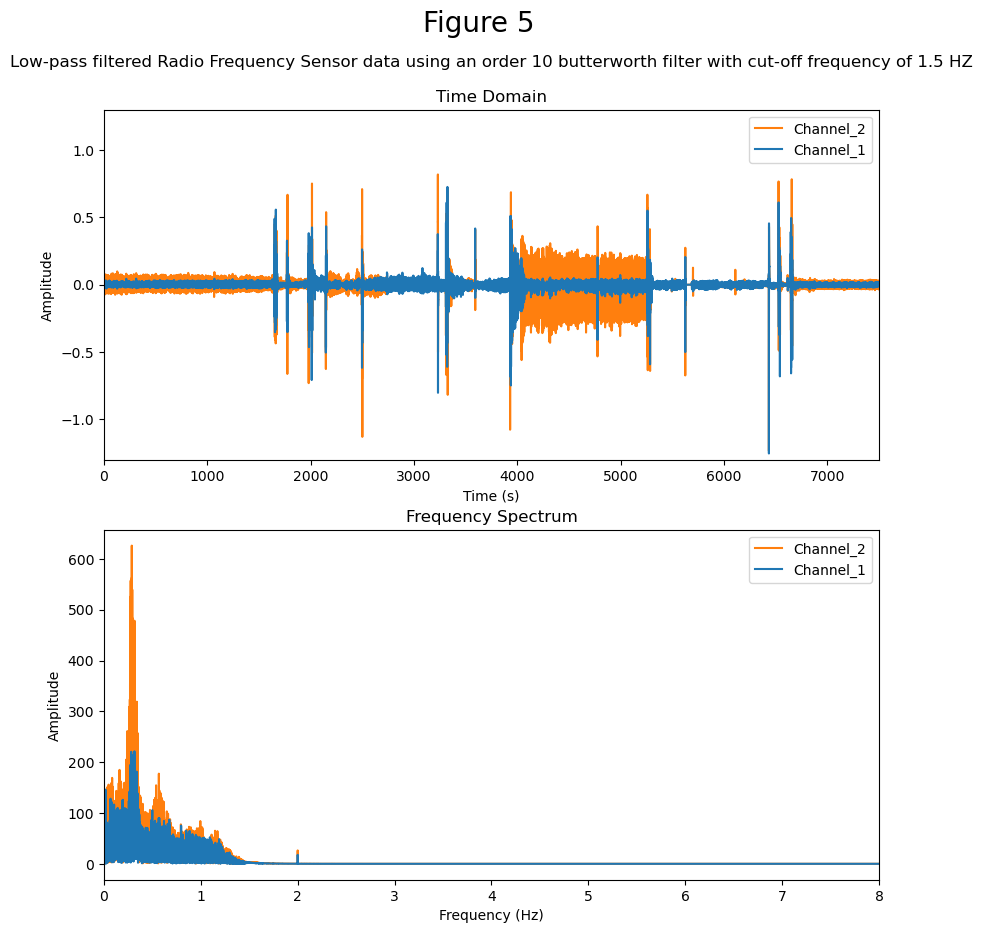

In [7]:
# use the previously created low-pass filter
LP_butterworth_filter = signal.butter(order, Wn, btype='low', analog=False, output='sos', fs = fsample)


# use the filter on the averaged signals
LP_filtered_avg_sig_1 = signal.sosfilt(LP_butterworth_filter, avg_sig_1)
LP_filtered_avg_sig_2 = signal.sosfilt(LP_butterworth_filter, avg_sig_2)

frequency_axis_LP = fftfreq(len(LP_filtered_avg_sig_1), 1/fs)[:len(LP_filtered_avg_sig_1)//2] # adjust frequency access to show appropriate spectrum

# plot the result from filtering the averaged signals
plt.figure(figsize=(10,10)).suptitle('Figure 5', fontsize=20)

plt.subplot(2, 1, 1)
plt.plot(time_axis, LP_filtered_avg_sig_2, color="#ff7f0e")
plt.plot(time_axis, LP_filtered_avg_sig_1, color="#1f77b4")
plt.legend(['Channel_2', 'Channel_1'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0, time_axis[-1]])
plt.ylim([-1.3, 1.3])
plt.title('Low-pass filtered Radio Frequency Sensor data using an order 10 butterworth filter with cut-off frequency of '+str(Wn)+' HZ\n\nTime Domain')

plt.subplot(2, 1, 2)
plt.plot(frequency_axis_LP, np.abs(fft(LP_filtered_avg_sig_2))[0:N//2], color="#ff7f0e")
plt.plot(frequency_axis_LP, np.abs(fft(LP_filtered_avg_sig_1))[0:N//2], color="#1f77b4")
plt.title('Frequency Spectrum')
plt.legend(['Channel_2', 'Channel_1'])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim([0, 8])
plt.show()

As shown above the 2 Hz frequency has been greatly attenuated in both signals. The now twice filtered signal will be investigated like the original signal before by investigating segments of the time domain signals to better understand how well the filter reduced noise in the signal. 

This filtering has also greatly reduced the sudden drop in both signals at roughly 5,700 seconds (however a sharp drop is still present). 

## 3.2 Look at a few time segments of the channels from the signals

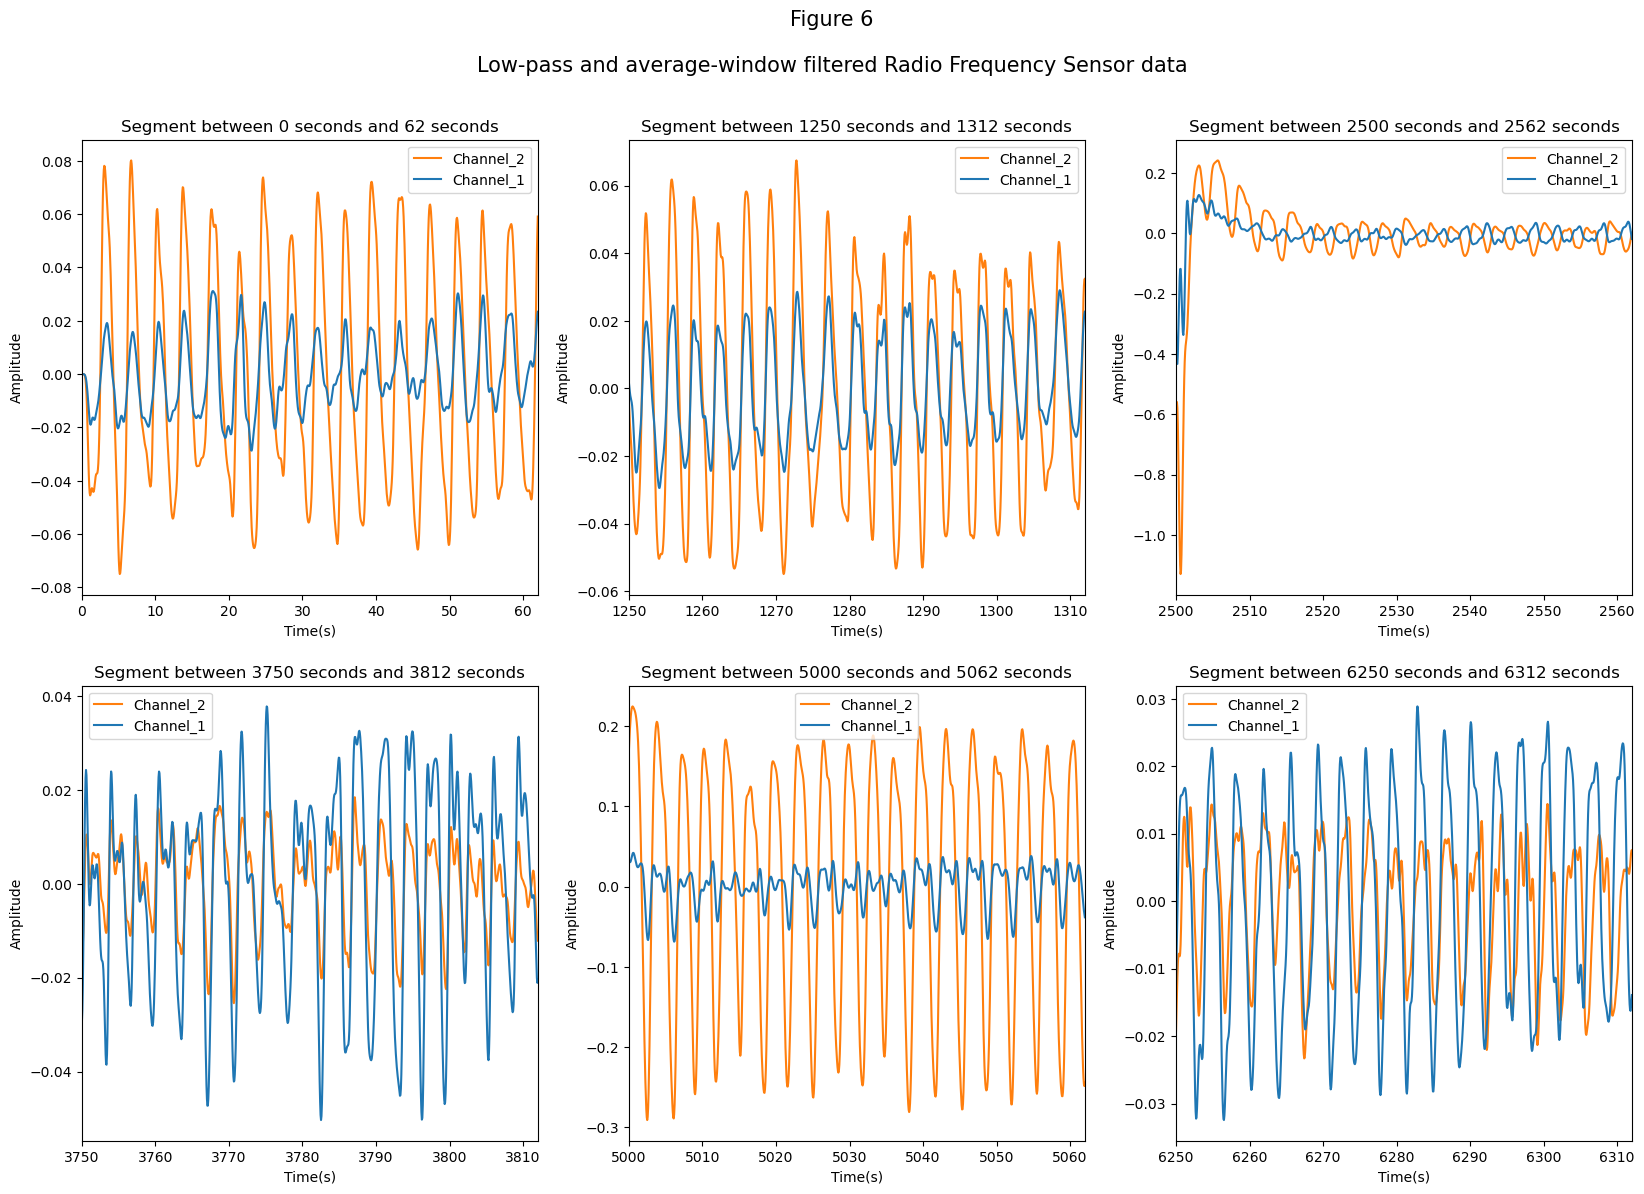

In [8]:
w = 1000 #number of samples in segment
ind = 0
plt.figure(figsize=(20,13)).suptitle('Figure 6\n\nLow-pass and average-window filtered Radio Frequency Sensor data', fontsize=15)

for i in range(0, N-w, w*20):
    ind+=1
    plt.subplot(2, 3, ind)
    time_axis_segment = np.linspace(i//fs, (i+w)//fs, w)
    plt.plot(time_axis_segment, LP_filtered_avg_sig_2[i:i+w], color="#ff7f0e")
    plt.plot(time_axis_segment, LP_filtered_avg_sig_1[i:i+w], color="#1f77b4")
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    plt.legend(['Channel_2', 'Channel_1'])
    plt.title('Segment between '+str(int(time_axis_segment[0]))+' seconds and '+str(int(time_axis_segment[-1]))+' seconds')
    plt.xlim([time_axis_segment[0], time_axis_segment[-1]])
plt.show()

Although the signals still have noise shown in certain sections in particular (top right figure and figures in the bottom row), the noise has been greatly reduced in regards to variability about the breath characteristics as shown in Figure 6 (top left and middle figures).

This reduction in noise proves that the low-pass 10th order Butterworth filter (with cut-off frequency of 1.5Hz) was successful for the variation reduction about the breathing characteristics shown in both radio frequency signals provided. 

The next step is to address the abnormal changes that remain in sections of the signal in order to detect an accurate breathing rate. 

## 4.0 Removal of remaining noise  

Compute the Short Time Fourier Transform (STFT) to better temporal frequencies that might be contributing to the noise at the various time points. 

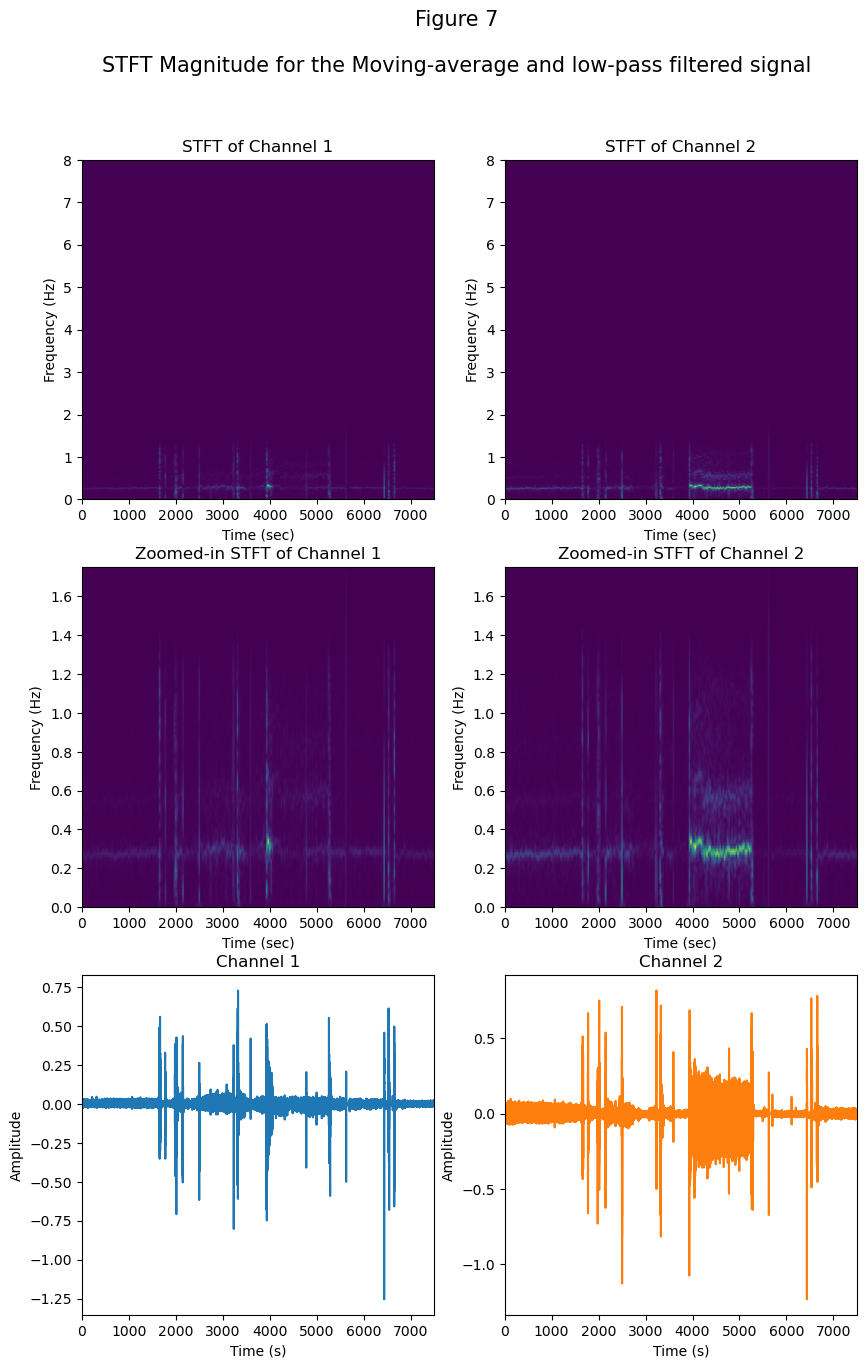

In [25]:
# calculate the STFT for both filtered signals
f_LP_filtered_avg_sig_1, t_LP_filtered_avg_sig_1, Zxx_LP_filtered_avg_sig_1 = signal.stft(LP_filtered_avg_sig_1, fs, nperseg=1000)
f_LP_filtered_avg_sig_2, t_LP_filtered_avg_sig_2, Zxx_LP_filtered_avg_sig_2 = signal.stft(LP_filtered_avg_sig_2, fs, nperseg=1000)

# plot the STFT
plt.figure(figsize=(10,15)).suptitle('Figure 7\n\nSTFT Magnitude for the Moving-average and low-pass filtered signal', fontsize=15)
plt.subplot(3, 2, 1)
plt.pcolormesh(t_LP_filtered_avg_sig_1, f_LP_filtered_avg_sig_1, np.abs(Zxx_LP_filtered_avg_sig_1), shading='gouraud')
plt.title('STFT of Channel 1')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.xlim([0, time_axis[-1]])

plt.subplot(3, 2, 2)
plt.pcolormesh(t_LP_filtered_avg_sig_2, f_LP_filtered_avg_sig_2, np.abs(Zxx_LP_filtered_avg_sig_2), shading='gouraud')
plt.title('STFT of Channel 2')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.xlim([0, time_axis[-1]])

# plot zoomed-in version of the STFT above to better see the frequencies at play
plt.subplot(3, 2, 3)
plt.pcolormesh(t_LP_filtered_avg_sig_1, f_LP_filtered_avg_sig_1, np.abs(Zxx_LP_filtered_avg_sig_1), shading='gouraud')
plt.title('Zoomed-in STFT of Channel 1')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.ylim([0, 1.75]) # limit chosen by visual inspection

plt.subplot(3, 2, 4)
plt.pcolormesh(t_LP_filtered_avg_sig_2, f_LP_filtered_avg_sig_2, np.abs(Zxx_LP_filtered_avg_sig_2), shading='gouraud')
plt.title('Zoomed-in STFT of Channel 2')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.ylim([0, 1.75]) # limit chosen by visual inspection
plt.xlim([0, time_axis[-1]])

#plot the signals in the time frequency domain underneath
plt.subplot(3, 2, 5)
plt.plot(time_axis, LP_filtered_avg_sig_1, color="#1f77b4")
plt.title('Channel 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0, time_axis[-1]])

plt.subplot(3, 2, 6)
plt.plot(time_axis, LP_filtered_avg_sig_2, color="#ff7f0e")
plt.title('Channel 2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0, time_axis[-1]])

plt.show()

From the zoomed-in STFT images above along side the filtered signals in Figure 7 - it is evident that there are frequencies that become dominant during the periods of increased noise of the signal.

Although it is evident that a time-dependent varying frequency is required (i.e to filter out these high magnitude frequencies at the time of noise, a simpler version of a filter will be used which will try and reduce these frequencies across the entire signal. From visual inspection, the frequencies we want to reduce are between 0.01:1.4Hz. A major limitation of this is that it will reduce about the 0.333Hz frequency which is expected to hold the most information for breathing. 

For this reason two bandstop filters will be created between 0.01:0.2 and another between 0.4:1.4Hz. To reduce the effect of multiple filters on the signal, the signals that were outputted from the moving average filter will be used - therefore to add this previously created filter's cut off the second bandstop filter will stop frequencies between 0.4:2.4Hz (to include the 2Hz noise).

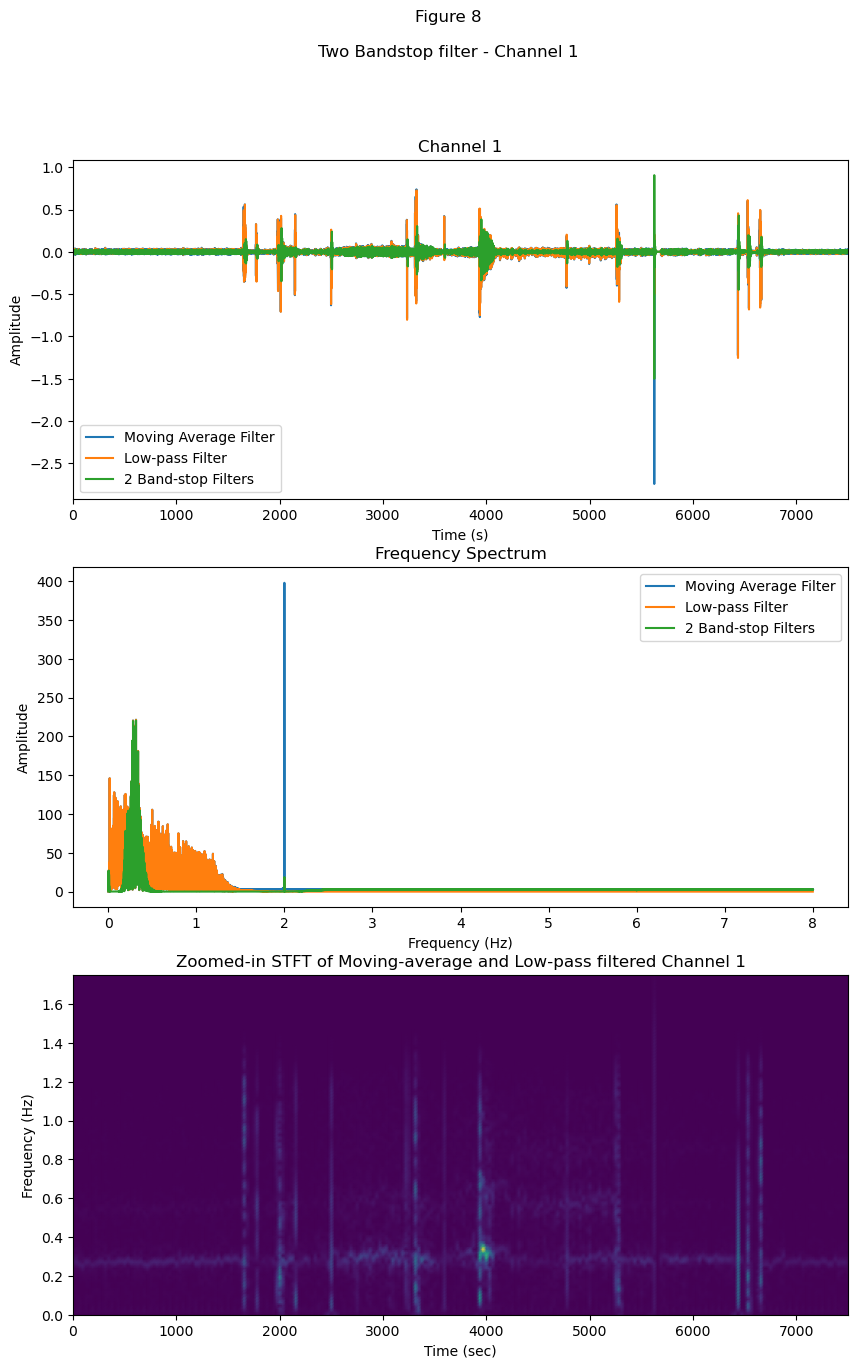

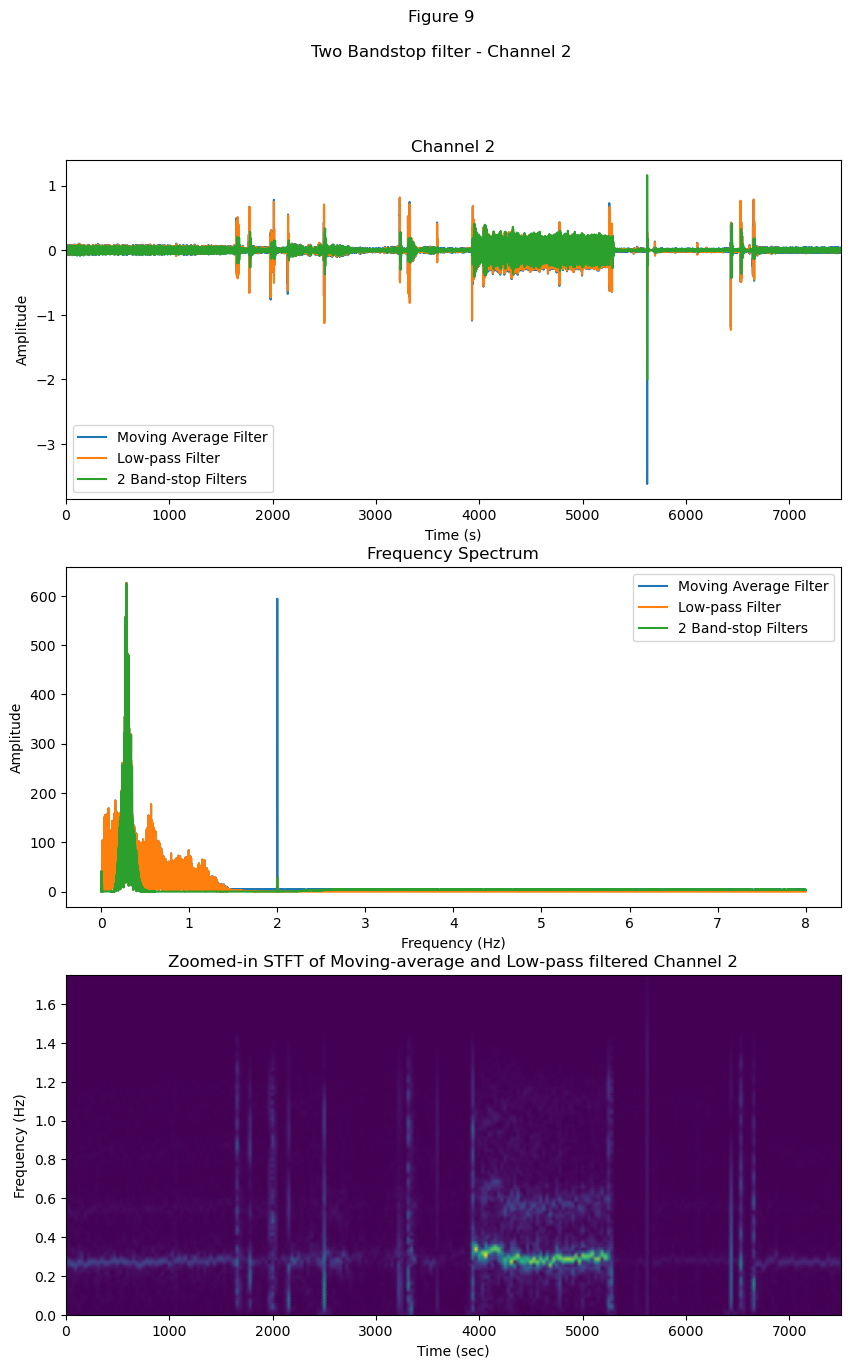

In [10]:
BS_freq_1 = [0.01, 0.2]
BS_freq_2 = [0.4, 2.4]
order = 10

BS1_butterworth_filter = signal.butter(order, BS_freq_1, btype='bandstop', analog=False, output='sos', fs = fs)
BS2_butterworth_filter = signal.butter(order, BS_freq_2, btype='bandstop', analog=False, output='sos', fs = fs)

# use the filter on the averaged signals
BS1_filtered_avg_sig_1 = signal.sosfilt(BS1_butterworth_filter, avg_sig_1.tolist())
BS12_filtered_avg_sig_1 = signal.sosfilt(BS2_butterworth_filter, BS1_filtered_avg_sig_1)

BS1_filtered_avg_sig_2 = signal.sosfilt(BS1_butterworth_filter, avg_sig_2.tolist())
BS12_filtered_avg_sig_2 = signal.sosfilt(BS2_butterworth_filter, BS1_filtered_avg_sig_2)


# calculate the STFT for both filtered signals
f_BS_12_sig_1, t_BS_12_sig_1, Zxx_BS_12_sig_1 = signal.stft(BS12_filtered_avg_sig_1, fs, nperseg=1000)
f_BS_12_sig_2, t_BS_12_sig_2, Zxx_BS_12_sig_2 = signal.stft(BS12_filtered_avg_sig_2, fs, nperseg=1000)


plt.figure(figsize=(10,15)).suptitle('Figure 8\n\nTwo Bandstop filter - Channel 1')
plt.subplot(3, 1, 1)
plt.plot(time_axis, avg_sig_1)
plt.plot(time_axis, LP_filtered_avg_sig_1)
plt.plot(time_axis, BS12_filtered_avg_sig_1)
plt.legend(['Moving Average Filter', 'Low-pass Filter', '2 Band-stop Filters'])
plt.title('Channel 1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0, time_axis[-1]])

plt.subplot(3, 1, 2)
plt.plot(frequency_axis, np.abs(fft(avg_sig_1.tolist()))[0:N//2])
plt.plot(frequency_axis, np.abs(fft(LP_filtered_avg_sig_1))[0:N//2])
plt.plot(frequency_axis, np.abs(fft(BS12_filtered_avg_sig_1))[0:N//2])
plt.title('Frequency Spectrum')
plt.legend(['Moving Average Filter', 'Low-pass Filter', '2 Band-stop Filters'])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 3)
plt.pcolormesh(t_LP_filtered_avg_sig_1, f_LP_filtered_avg_sig_1, np.abs(Zxx_LP_filtered_avg_sig_1), shading='gouraud')
plt.title('Zoomed-in STFT of Moving-average and Low-pass filtered Channel 1')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.ylim([0, 1.75]) # limit chosen by visual inspection
plt.show()

plt.figure(figsize=(10,15)).suptitle('Figure 9\n\nTwo Bandstop filter - Channel 2')
plt.subplot(3, 1, 1)
plt.plot(time_axis, avg_sig_2)
plt.plot(time_axis, LP_filtered_avg_sig_2)
plt.plot(time_axis, BS12_filtered_avg_sig_2)
plt.legend(['Moving Average Filter', 'Low-pass Filter', '2 Band-stop Filters'])
plt.title('Channel 2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0, time_axis[-1]])

plt.subplot(3, 1, 2)
plt.plot(frequency_axis, np.abs(fft(avg_sig_2.tolist()))[0:N//2])
plt.plot(frequency_axis, np.abs(fft(LP_filtered_avg_sig_2))[0:N//2])
plt.plot(frequency_axis, np.abs(fft(BS12_filtered_avg_sig_2))[0:N//2])
plt.title('Frequency Spectrum')
plt.legend(['Moving Average Filter', 'Low-pass Filter', '2 Band-stop Filters'])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 3)
plt.pcolormesh(t_LP_filtered_avg_sig_2, f_LP_filtered_avg_sig_2, np.abs(Zxx_LP_filtered_avg_sig_2), shading='gouraud')
plt.title('Zoomed-in STFT of Moving-average and Low-pass filtered Channel 2')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.ylim([0, 1.75]) # limit chosen by visual inspection
plt.xlim([0, time_axis[-1]])
plt.show()

From Figure 8 and 9 above, it is evident that using the two band-stop filters reduce the amplitude of noise at the noisey intervals aforementioned. However, the reduction in noise is small and therefore the low-pass filter might be sufficient as using two filters adds more of a change in phase response for particular frequencies in the signal. 

However, this means that the breath detection algorithm outlined below will have to have additional conditions such that it can detect the most accurate breath rate it can for most of the signal. Because these noisey parts of the signal have not successfully been removed for the majority of the signal the breathing rate for these sections will not be accurate - this is a major limitation of this algorithm.

## 4.1 Welch's Method for each approach

In [11]:
f_sig_1, Pxx_spec_sig_1 = signal.welch(signals['Channel_1'], fs, 'flattop', 1024, scaling='spectrum')
f_sig_2, Pxx_spec_sig_2 = signal.welch(signals['Channel_2'], fs, 'flattop', 1024, scaling='spectrum')
                                       
f_avg_sig_1, Pxx_spec_avg_sig_1 = signal.welch(avg_sig_1, fs, 'flattop', 1024, scaling='spectrum')
f_avg_sig_2, Pxx_spec_avg_sig_2 = signal.welch(avg_sig_2, fs, 'flattop', 1024, scaling='spectrum')

f_sig_lp_1, Pxx_spec_sig_lp_1 = signal.welch(LP_filtered_avg_sig_1, fs, 'flattop', 1024, scaling='spectrum')
f_sig_lp_2, Pxx_spec_sig_lp_2 = signal.welch(LP_filtered_avg_sig_2, fs, 'flattop', 1024, scaling='spectrum')

Plot the frequency spectra

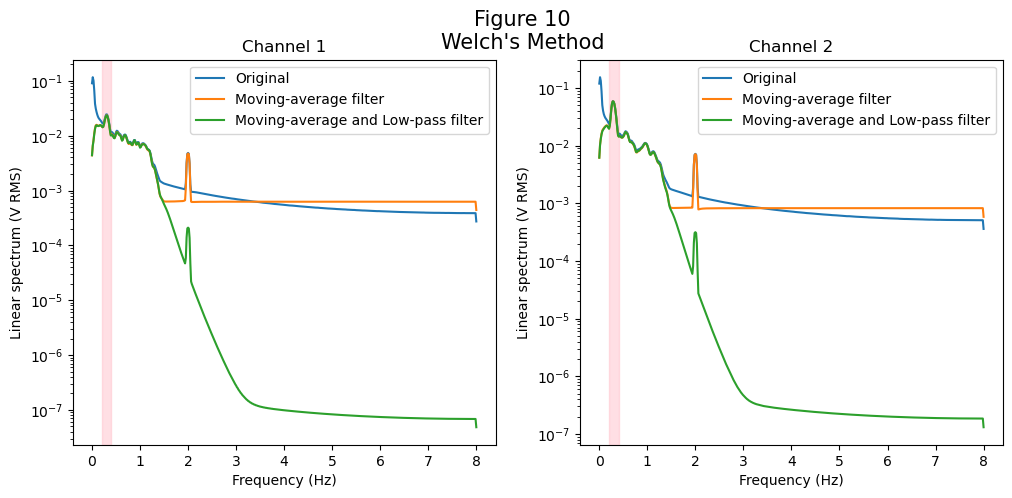

In [12]:
plt.figure(figsize=(12,5)).suptitle("Figure 10\nWelch's Method", fontsize=15)

plt.subplot(1, 2, 1)
plt.title("Channel 1")
plt.semilogy(f_sig_1, np.sqrt(Pxx_spec_sig_1))
plt.semilogy(f_avg_sig_1, np.sqrt(Pxx_spec_avg_sig_1))
plt.semilogy(f_sig_lp_1, np.sqrt(Pxx_spec_sig_lp_1))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Linear spectrum (V RMS)')
plt.legend(['Original', 'Moving-average filter', 'Moving-average and Low-pass filter'])
plt.axvspan(0.2, 0.4, alpha=0.5, color='pink')

plt.subplot(1, 2, 2)
plt.semilogy(f_sig_2, np.sqrt(Pxx_spec_sig_2))
plt.semilogy(f_avg_sig_2, np.sqrt(Pxx_spec_avg_sig_2))
plt.semilogy(f_sig_lp_2, np.sqrt(Pxx_spec_sig_lp_2))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Linear spectrum (V RMS)')
plt.title("Channel 2")
plt.legend(['Original', 'Moving-average filter', 'Moving-average and Low-pass filter'])
plt.axvspan(0.2, 0.4, alpha=0.5, color='pink')
plt.show()

## 5.0 Detecting Breaths

Using scipy's find_peaks() function, identify the positive peaks (i.e. the breaths) of both signals:

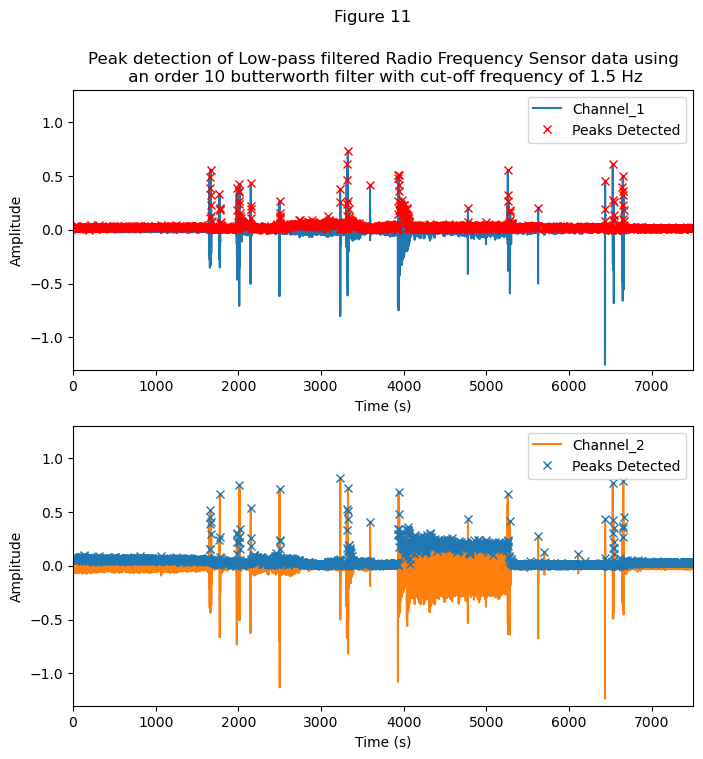

In [13]:
#detect the breath peaks
breath_frequency_approx = 1/3 # roughly 20 breaths every 60 seconds which is 0.333 breaths every second
distance = fs*1.25 # samples between each peak detected - i.e. ~time between each breath => 20 samples between each breath or 1.25 seconds
approx_breath_width = 4 # sample distance from visual inspection
min_height = 0.001 # from visual inspection - we also want to be sure that we only detect the postive peaks - otherwise we would get double the rate of breaths

peaks_detected_LP_avg_sig_1, _ = find_peaks(LP_filtered_avg_sig_1, height=min_height, threshold=None, distance=distance, prominence=None, width=approx_breath_width, wlen=None, rel_height=0.5, plateau_size=None)
peaks_detected_LP_avg_sig_2, _ = find_peaks(LP_filtered_avg_sig_2, height=min_height, threshold=None, distance=distance, prominence=None, width=approx_breath_width, wlen=None, rel_height=0.5, plateau_size=None)

plt.figure(figsize=(8,8)).suptitle('Figure 11')
plt.subplot(2, 1, 1)
plt.plot(time_axis, LP_filtered_avg_sig_1, color="#1f77b4")
plt.plot(peaks_detected_LP_avg_sig_1/fs, LP_filtered_avg_sig_1[peaks_detected_LP_avg_sig_1], "x", color="r") # divide peaks by sampling frequency such that both signal and peaks can be plotted in the same units of seconds

plt.legend(['Channel_1', 'Peaks Detected'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0, time_axis[-1]])
# plt.xlim([0, 60])
# plt.ylim([-0.03, 0.03])
plt.ylim([-1.3, 1.3])
plt.title('Peak detection of Low-pass filtered Radio Frequency Sensor data using\n an order 10 butterworth filter with cut-off frequency of '+str(Wn)+' Hz')


plt.subplot(2, 1, 2)
plt.plot(time_axis, LP_filtered_avg_sig_2, color="#ff7f0e")
plt.plot(peaks_detected_LP_avg_sig_2/fs, LP_filtered_avg_sig_2[peaks_detected_LP_avg_sig_2], "x") # divide peaks by sampling frequency such that both signal and peaks can be plotted in the same units of seconds

plt.legend(['Channel_2', 'Peaks Detected'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0, time_axis[-1]])
plt.ylim([-1.3, 1.3])

plt.show()

We shall now inspect sections of the signal as done before to understand better how accurately the appropriate peaks are being detected.

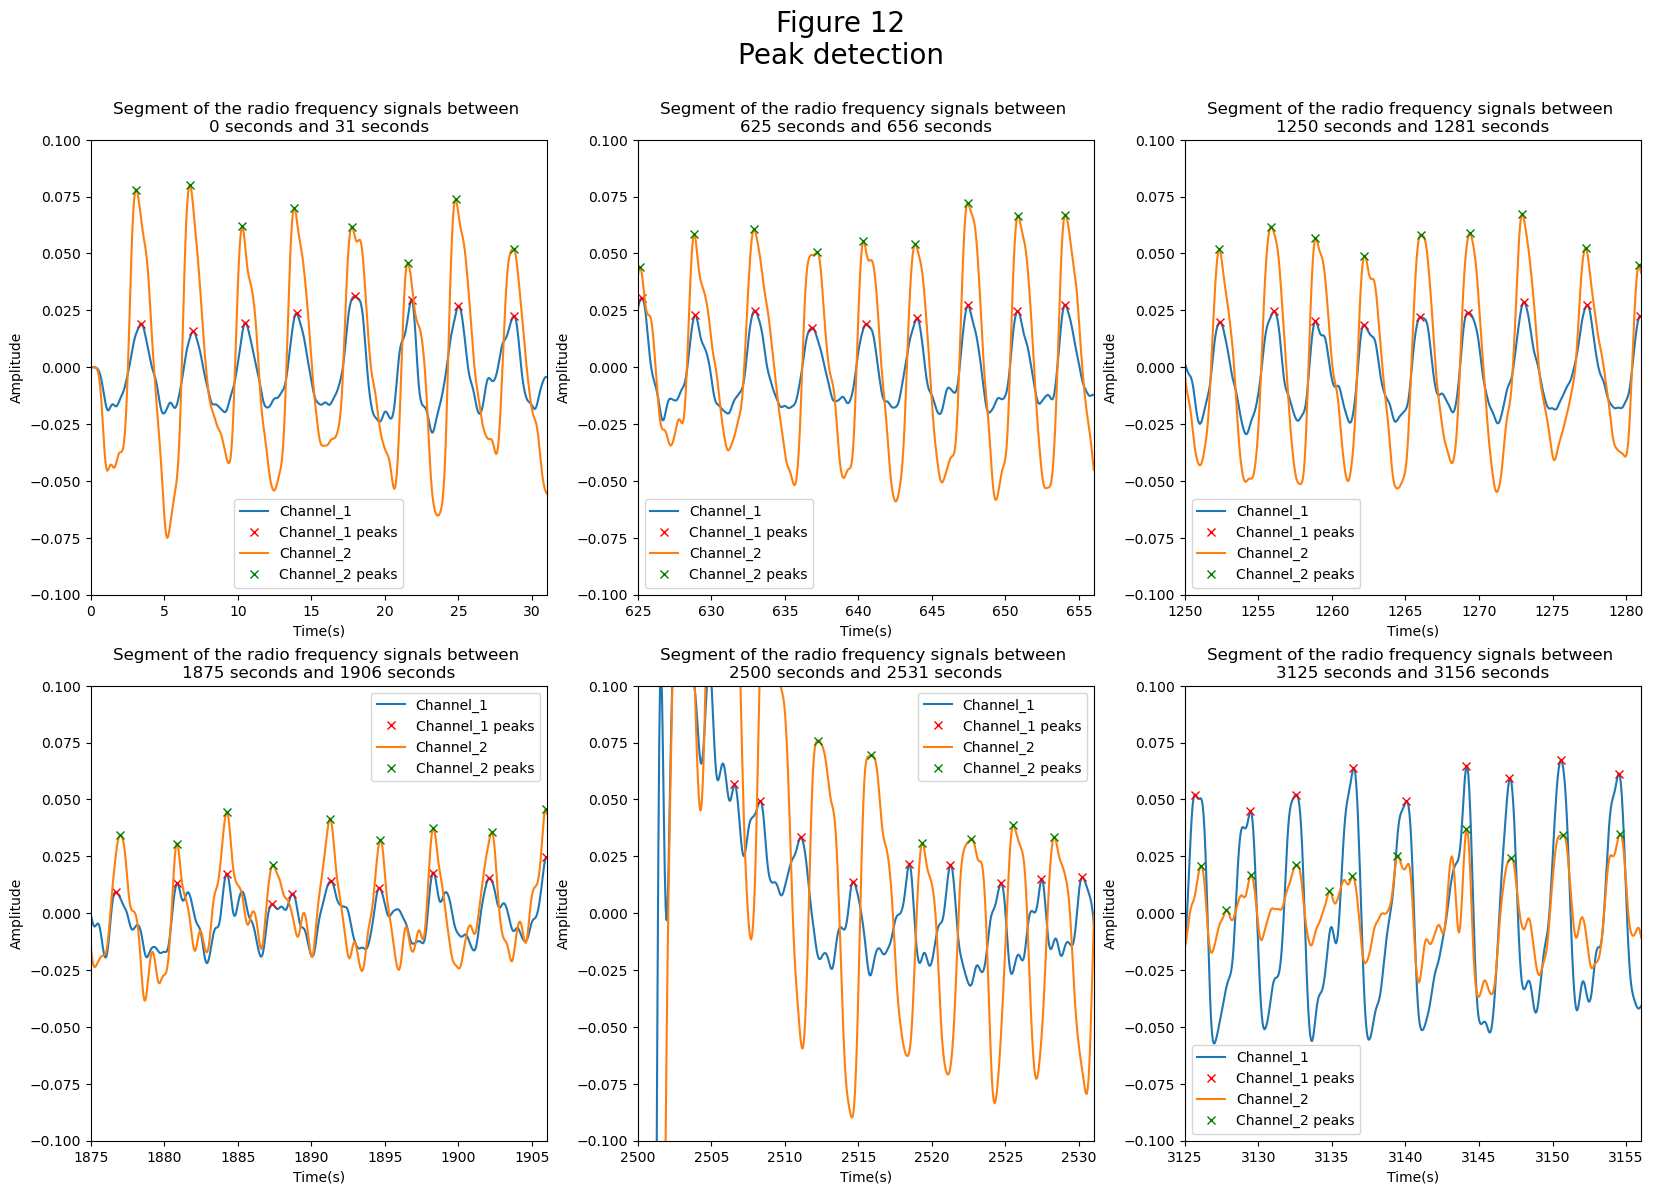

In [28]:
w = 500 #number of samples in segment
ind = 0
plt.figure(figsize=(20,13)).suptitle('Figure 12\nPeak detection', fontsize=20)

for i in range(0, N-w, w*20):
    ind+=1
    plt.subplot(2, 3, ind)
    time_axis_segment = np.linspace(i//fs, (i+w)//fs, w)
    plt.plot(time_axis, LP_filtered_avg_sig_1, color="#1f77b4")
    plt.plot(peaks_detected_LP_avg_sig_1/fs, LP_filtered_avg_sig_1[peaks_detected_LP_avg_sig_1], "x", color="r") # divide peaks by sampling frequency such that both signal and peaks can be plotted in the same units of seconds
    plt.plot(time_axis, LP_filtered_avg_sig_2, color="#ff7f0e")
    plt.plot(peaks_detected_LP_avg_sig_2/fs, LP_filtered_avg_sig_2[peaks_detected_LP_avg_sig_2], "x", color="g") # divide peaks by sampling frequency such that both signal and peaks can be plotted in the same units of seconds
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    plt.title('Segment of the radio frequency signals between \n'+str(int(time_axis_segment[0]))+' seconds and '+str(int(time_axis_segment[-1]))+' seconds')
    plt.xlim([time_axis_segment[0], time_axis_segment[-1]])
    plt.legend(['Channel_1', 'Channel_1 peaks', 'Channel_2', 'Channel_2 peaks'])
    plt.ylim([-0.1, 0.1])
    if ind == 6:
        break
plt.show()

As shown above the peak detection algorithm does okay at detecting when peaks, or in case breaths occur - particularly for Channel 1. 

Now that we have detected breath, we need to feed this information into another algorithm that counts the peaks in a 30 second window and provides a breathing rate for each window in units of breaths/ minute.

## 6.0 Create the breathing rate calculation algorithm function

In [15]:
# create a for loop that goes between sample i:i+analysis_window to count the number of breaths 
# in 30 seconds and then move to the next 30 second segment 

def breath_30_sec_avg_rate(sig, duration_seconds, sig_peaks, fs):
    duration_seconds = 30 # seconds
    analysis_window = duration_seconds*fs
    breath_rate_per_min = []

    for i in range(0, len(sig), analysis_window):
        num_of_breaths_30sec = len(np.where(np.logical_and(sig_peaks>=i, sig_peaks<=i+analysis_window))[0])
        avg_num_breath_30_sec = num_of_breaths_30sec/duration_seconds # get breath per second
        breath_rate_per_min.append(avg_num_breath_30_sec*60) # 30 seconds * 2 is 60 seconds = 1 minute
        rate_time_axis = range(0, len(breath_rate_per_min)*duration_seconds, duration_seconds)
    
    return rate_time_axis, breath_rate_per_min

This breathing rate function will not be used on the signals:

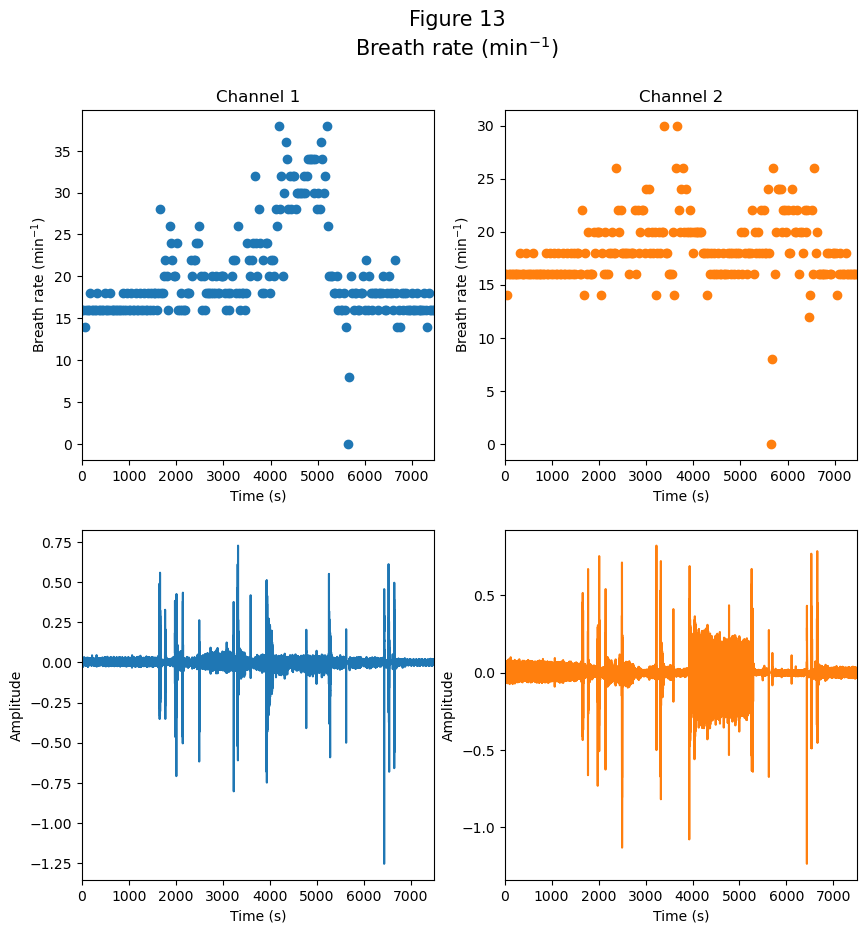

In [16]:
duration_seconds = 30 # seconds
rate_time_axis_1, breath_per_min_LP_filtered_avg_sig_1 =  breath_30_sec_avg_rate(LP_filtered_avg_sig_1, duration_seconds, peaks_detected_LP_avg_sig_1, fs)
rate_time_axis_2, breath_per_min_LP_filtered_avg_sig_2 =  breath_30_sec_avg_rate(LP_filtered_avg_sig_2, duration_seconds, peaks_detected_LP_avg_sig_2, fs)


plt.figure(figsize=(10,10)).suptitle('Figure 13\nBreath rate ($\mathregular{min^{-1}}$)', fontsize=15)

plt.subplot(2, 2, 1)
plt.plot(rate_time_axis_1,  breath_per_min_LP_filtered_avg_sig_1, 'o', color="#1f77b4")
plt.title('Channel 1')
plt.ylabel('Breath rate ($\mathregular{min^{-1}}$)')
plt.xlabel('Time (s)')
plt.xlim([0, rate_time_axis_1[-1]])

plt.subplot(2, 2, 2)
plt.plot(rate_time_axis_2,  breath_per_min_LP_filtered_avg_sig_2, 'o', color="#ff7f0e")
plt.title('Channel 2')
plt.ylabel('Breath rate ($\mathregular{min^{-1}}$)')
plt.xlabel('Time (s)')
plt.xlim([0, rate_time_axis_2[-1]])

plt.subplot(2, 2, 3)
plt.plot(time_axis, LP_filtered_avg_sig_1, color="#1f77b4")
plt.xlim([0, time_axis[-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 2, 4)
plt.plot(time_axis, LP_filtered_avg_sig_2, color="#ff7f0e")
plt.xlim([0, time_axis[-1]])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Appendix
## Alternative Method #1: A bandpass filter (0.1-0.4Hz)

A Butterworth Bandpass filter was investigated, however, it was unsuccessful in reducing the signal noise.

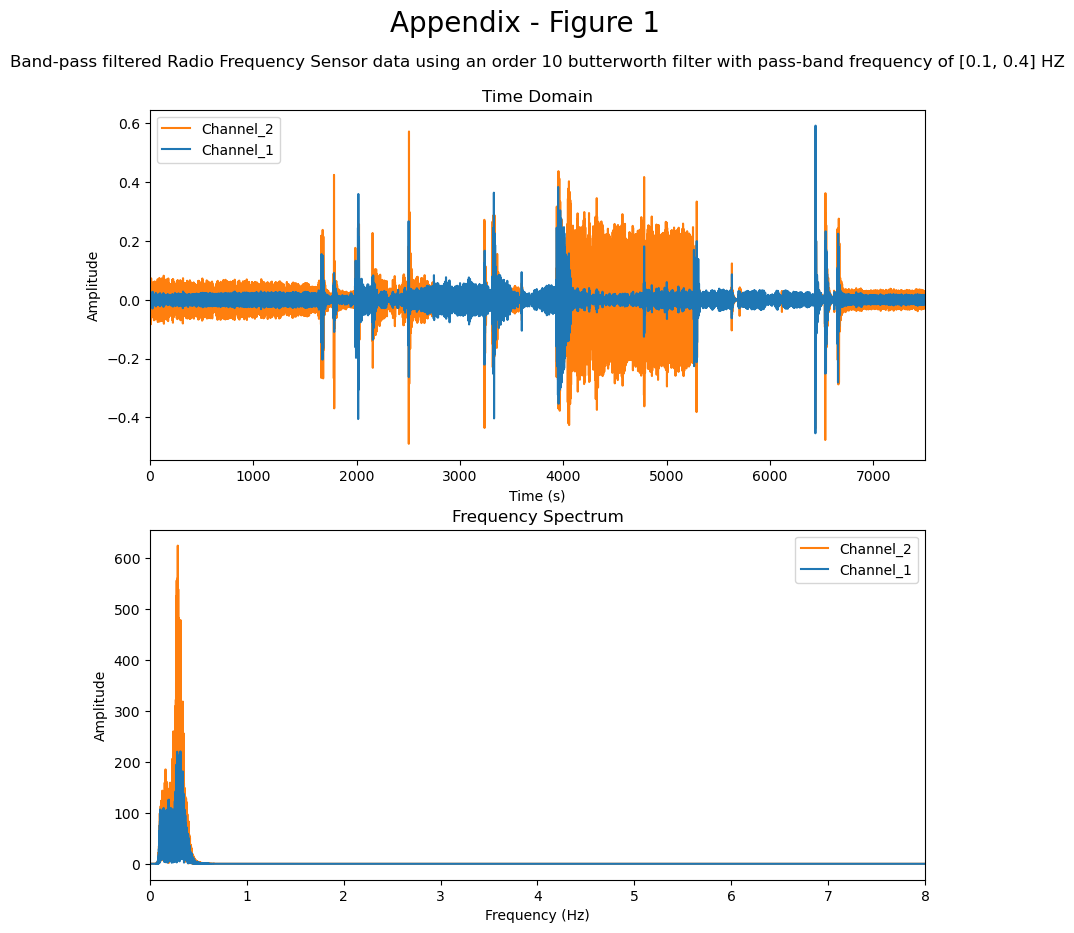

In [23]:
# use the previously created low-pass filter
Wn = [0.1, 0.4]
BP_butterworth_filter = signal.butter(order, Wn, btype='bandpass', analog=False, output='sos', fs = fsample)


# use the filter on the averaged signals
BP_filtered_avg_sig_1 = signal.sosfilt(BP_butterworth_filter, avg_sig_1)
BP_filtered_avg_sig_2 = signal.sosfilt(BP_butterworth_filter, avg_sig_2)

frequency_axis_BP = fftfreq(len(BP_filtered_avg_sig_1), 1/fs)[:len(BP_filtered_avg_sig_1)//2] # adjust frequency access to show appropriate spectrum

# plot the result from filtering the averaged signals
plt.figure(figsize=(10,10)).suptitle('Appendix - Figure 1', fontsize=20)

plt.subplot(2, 1, 1)
plt.plot(time_axis, BP_filtered_avg_sig_2, color="#ff7f0e")
plt.plot(time_axis, BP_filtered_avg_sig_1, color="#1f77b4")
plt.legend(['Channel_2', 'Channel_1'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0, time_axis[-1]])
# plt.ylim([-1.3, 1.3])
plt.title('Band-pass filtered Radio Frequency Sensor data using an order 10 butterworth filter with pass-band frequency of '+str(Wn)+' HZ\n\nTime Domain')

plt.subplot(2, 1, 2)
plt.plot(frequency_axis_BP, np.abs(fft(BP_filtered_avg_sig_2))[0:N//2], color="#ff7f0e")
plt.plot(frequency_axis_BP, np.abs(fft(BP_filtered_avg_sig_1))[0:N//2], color="#1f77b4")
plt.title('Frequency Spectrum')
plt.legend(['Channel_2', 'Channel_1'])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim([0, 8])
plt.show()

However, evidently from the Figure above, it was not successful in removing any of the unwanted noise because of the noise issue identfied in Figure 7

## Alternative Method #2: Cross-correlation and Time-varing Filters

Because of the noisey frequencies identified at specific sections of the signal, a methos to identify and filter out these frequencies could be achieved. 

As the noise is almost consistently common among the signals, the cross-correlation of the signals could indentify these sections of high noise and provide almost a  time-stamp to when the noise is occuring and thus providing the opportunity to filter these segments once the noisey frequencies are identified. 

Two bandstop filter could be used at these time points to block the frequencies that contribute noise to the signal.

Below you will find the normalised cross-correlations of the original signal, moving averaged filtered signal and moving averaged and low-passed signal. 

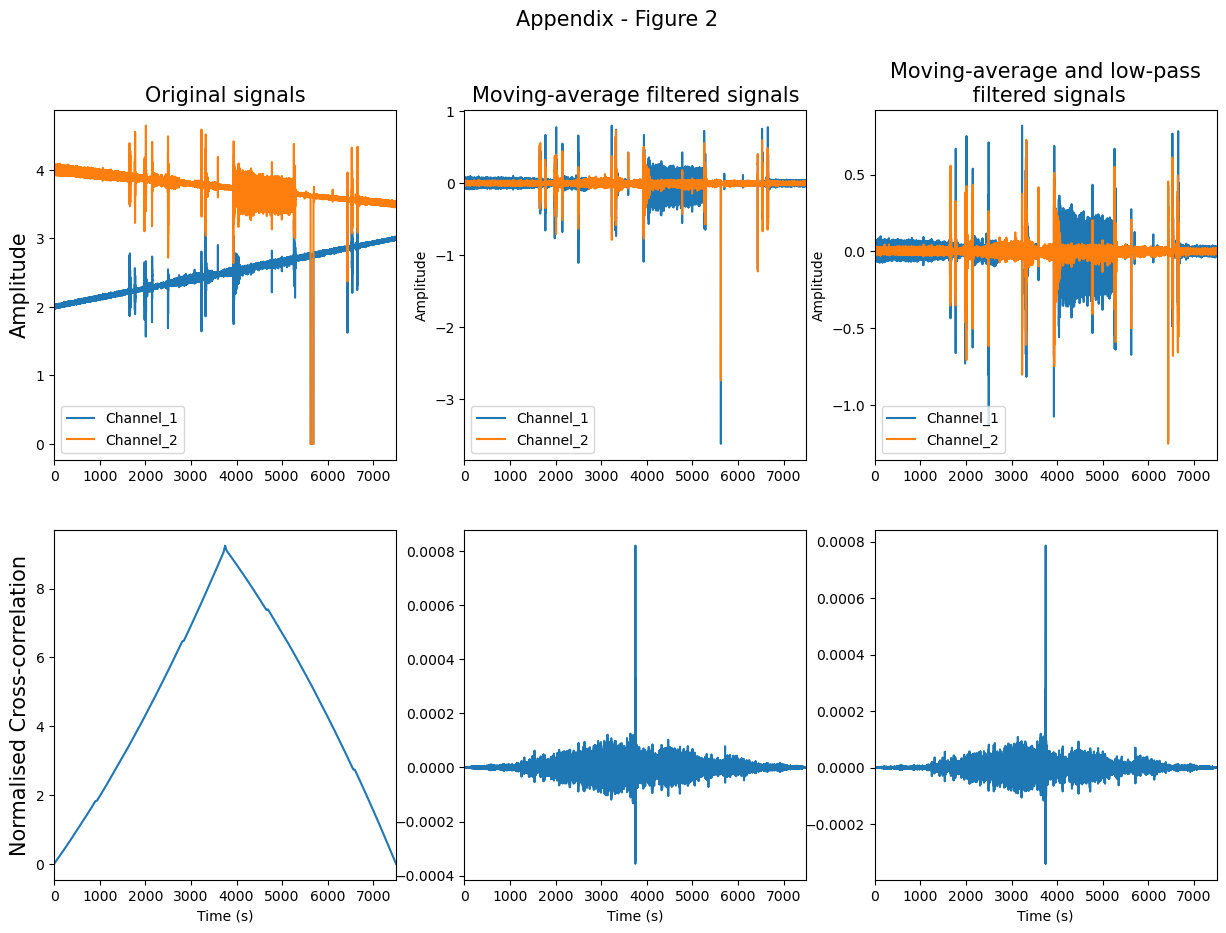

In [18]:
cross_corr_orig = signal.correlate(signals['Channel_1'], signals['Channel_2'])/len(signals['Channel_1'])
cross_corr_avg = signal.correlate(avg_sig_1, avg_sig_2)/ len(signal.correlate(avg_sig_1, avg_sig_2))
cross_corr_LP_fil = signal.correlate(LP_filtered_avg_sig_1, LP_filtered_avg_sig_2)/len(signal.correlate(LP_filtered_avg_sig_1, LP_filtered_avg_sig_2))

time_cross_corr = np.linspace(0, (len(cross_corr_orig)/fs)/2, len(cross_corr_orig)) # convert into time in order to compare the signals over time alongside

plt.figure(figsize=(15,10)).suptitle('Appendix - Figure 2', fontsize=15)
plt.subplot(2, 3, 1)
plt.plot(time_axis, signals)
plt.legend(['Channel_1', 'Channel_2'])
plt.ylabel('Amplitude', fontsize=15)
plt.title('Original signals', fontsize=15)
plt.xlim([0, time_axis[-1]])

plt.subplot(2, 3, 4)
plt.plot(time_cross_corr, cross_corr_orig)
plt.xlabel('Time (s)')
plt.ylabel('Normalised Cross-correlation', fontsize=15)
plt.xlim([0, time_cross_corr[-1]])

plt.subplot(2, 3, 2)
plt.plot(time_axis, avg_sig_2)
plt.plot(time_axis, avg_sig_1)
plt.legend(['Channel_1', 'Channel_2'])
plt.xlim([0, time_axis[-1]])
# plt.xlabel('Time (s)')
plt.title('Moving-average filtered signals', fontsize=15)
plt.ylabel('Amplitude')

plt.subplot(2, 3, 5)
plt.plot(time_cross_corr, cross_corr_avg)
plt.xlabel('Time (s)')
plt.xlim([0, time_cross_corr[-1]])

plt.subplot(2, 3, 3)
plt.plot(time_axis, LP_filtered_avg_sig_2)
plt.plot(time_axis, LP_filtered_avg_sig_1)
plt.legend(['Channel_1', 'Channel_2'])
# plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0, time_axis[-1]])
plt.title('Moving-average and low-pass\n filtered signals', fontsize=15)

plt.subplot(2, 3, 6)
plt.plot(time_cross_corr, cross_corr_LP_fil)
plt.xlabel('Time (s)')
plt.xlim([0, time_cross_corr[-1]])
plt.show()

As the cross-correlation of the moving average and low-pass and moving average signals have similar normalised cross-correlation values, to reduce the amount of phase distortion, the moving averaged signal will be chosen for this. 

A clearer Figure of this normalised cross-correlation is shown below:

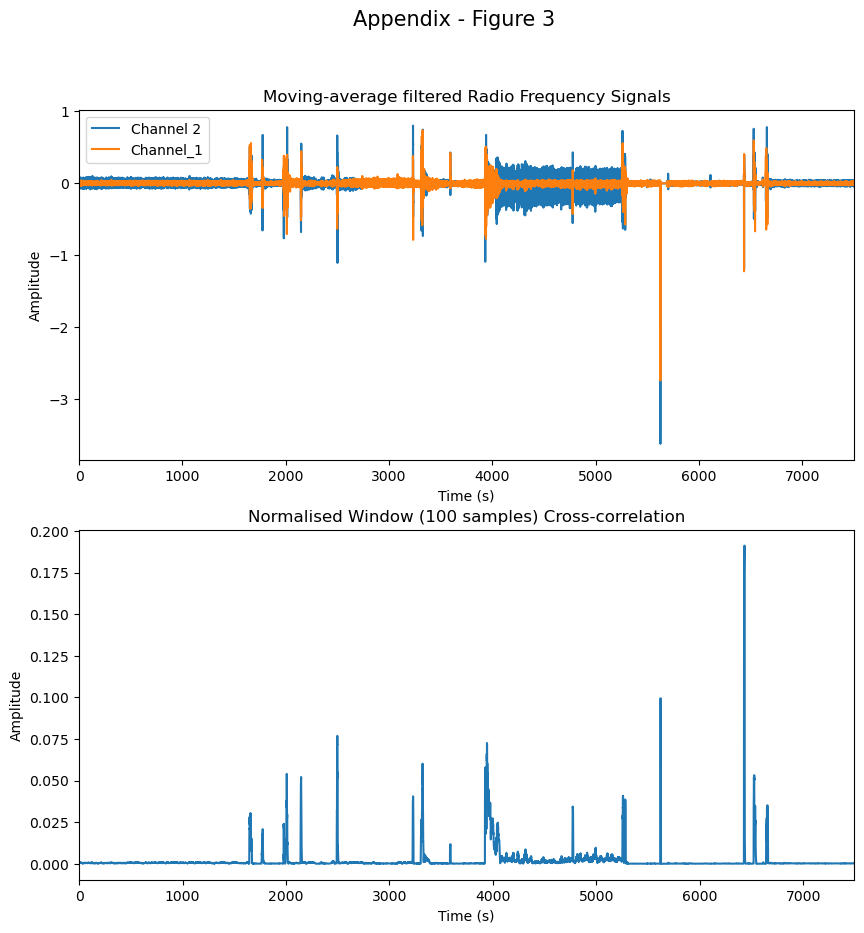

In [19]:
u = 100
corr_avg_seg = []

for i in range(0, len(avg_sig_1)-u):
    corr_seg = []
    corr_seg = np.max(signal.correlate(avg_sig_1[i:i+u], avg_sig_2[i:i+u])/len(avg_sig_1[i:i+u]))
    corr_avg_seg.append(corr_seg)
    
time_axis_corr = np.linspace(0, len(corr_avg_seg)//fs, len(corr_avg_seg))

plt.figure(figsize=(10,10)).suptitle('Appendix - Figure 3', fontsize=15)
plt.subplot(2, 1, 1)
plt.plot(time_axis, avg_sig_2)
plt.plot(time_axis, avg_sig_1)
plt.title('Moving-average filtered Radio Frequency Signals')
plt.legend(['Channel 2', 'Channel_1'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0, time_axis[-1]])

plt.subplot(2, 1, 2)
plt.title('Normalised Window (100 samples) Cross-correlation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(time_axis_corr, corr_avg_seg)
plt.xlim([0, time_axis_corr[-1]])
plt.show()

This has successfully identified the locations where the main noise artefacts occur and therefore could be used to identify the noisey segments for later filtering. 

However, this alernative route was not further investigated.